<a href="https://colab.research.google.com/github/neelandrakar/sales_prediction_models/blob/main/Predict_Next_Sale_Test_v001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



**Dataset Import**

In [54]:
sale_dt = pd.read_csv("dealer_wise_sale.csv")
sale_dt['purchase_date'] = pd.to_datetime(sale_dt['purchase_date'])
sale_dt['PREV_INVOICE'] = pd.to_datetime(sale_dt['PREV_INVOICE'])
sale_dt['PREV_INVOICE_TWO'] = pd.to_datetime(sale_dt['PREV_INVOICE_TWO'])
sale_dt['PREV_INVOICE_THREE'] = pd.to_datetime(sale_dt['PREV_INVOICE_THREE'])

print(sale_dt.head(5))

   dealer_id purchase_date  purchase_rank PREV_INVOICE PREV_INVOICE_TWO  \
0       4886    2025-02-18              1   2025-02-14       2025-01-15   
1       4886    2025-02-14              2   2025-01-15       2024-11-27   
2       4886    2025-01-15              3   2024-11-27       2024-09-24   
3       4886    2024-11-27              4   2024-09-24       2024-08-22   
4       8045    2025-02-12              1   2024-12-24       2024-10-27   

  PREV_INVOICE_THREE  
0         2024-11-27  
1         2024-09-24  
2         2024-08-22  
3         2024-07-21  
4         2024-08-26  


**Creating a user dataframe**

In [55]:
sale_user = pd.DataFrame(sale_dt['dealer_id'].unique())
sale_user.columns = ['dealer_id']
print(sale_user);

     dealer_id
0         4886
1         8045
2        11702
3        12211
4        12280
..         ...
330  232977250
331  232977760
332  232979074
333  232980371
334  232980549

[335 rows x 1 columns]


**Calculation of date_diff between first and last purchases**

In [57]:
#create a dataframe with dealer_id and first purchase date in tx_next
sale_first_purchase = sale_dt.groupby('dealer_id').purchase_date.min().reset_index()
sale_first_purchase.columns = ['dealer_id','MinPurchaseDate']

#create a dataframe with dealer_id and last purchase date in tx_6m
sale_last_purchase = sale_dt.groupby('dealer_id').purchase_date.max().reset_index()
sale_last_purchase.columns = ['dealer_id','MaxPurchaseDate']

#merge two dataframes
purchase_dates = pd.merge(sale_last_purchase,sale_first_purchase,on='dealer_id',how='left')

#calculate the time difference in days:
purchase_dates['NextPurchaseDay'] = (purchase_dates['MaxPurchaseDate'] - purchase_dates['MinPurchaseDate']).dt.days

print('purchase_dates: \n',purchase_dates)
print('sale_user: \n',sale_user)

new_sale_user = pd.merge(sale_user,purchase_dates[['dealer_id','NextPurchaseDay']],on='dealer_id',how='left')
print('new_sale_user: \n',new_sale_user)



purchase_dates: 
      dealer_id MaxPurchaseDate MinPurchaseDate  NextPurchaseDay
0         4886      2025-02-18      2024-11-27               83
1         8045      2025-02-12      2024-08-26              170
2        11702      2025-02-20      2025-01-08               43
3        12211      2025-01-10      2024-02-21              324
4        12280      2025-02-16      2024-09-13              156
..         ...             ...             ...              ...
330  232977250      2025-02-03      2025-02-03                0
331  232977760      2025-02-05      2025-02-01                4
332  232979074      2025-02-13      2025-02-13                0
333  232980371      2025-02-15      2025-02-15                0
334  232980549      2025-02-14      2025-02-14                0

[335 rows x 4 columns]
sale_user: 
      dealer_id
0         4886
1         8045
2        11702
3        12211
4        12280
..         ...
330  232977250
331  232977760
332  232979074
333  232980371
334  2329805

In [106]:
new_sale_user

,dealer_id,NextPurchaseDay
0,4886,83
1,8045,170
2,11702,43
3,12211,324
4,12280,156
...,...,...
330,232977250,0
331,232977760,4
332,232979074,0
333,232980371,0


**Calculating Day Difference**

In [58]:
sale_dt['DayDiff'] = (sale_dt['purchase_date'] - sale_dt['PREV_INVOICE']).dt.days
sale_dt['DayDiffTwo'] = (sale_dt['purchase_date'] - sale_dt['PREV_INVOICE_TWO']).dt.days
sale_dt['DayDiffThree'] = (sale_dt['purchase_date'] - sale_dt['PREV_INVOICE_THREE']).dt.days
print(sale_dt.head(5))

   dealer_id purchase_date  purchase_rank PREV_INVOICE PREV_INVOICE_TWO  \
0       4886    2025-02-18              1   2025-02-14       2025-01-15   
1       4886    2025-02-14              2   2025-01-15       2024-11-27   
2       4886    2025-01-15              3   2024-11-27       2024-09-24   
3       4886    2024-11-27              4   2024-09-24       2024-08-22   
4       8045    2025-02-12              1   2024-12-24       2024-10-27   

  PREV_INVOICE_THREE  DayDiff  DayDiffTwo  DayDiffThree  
0         2024-11-27      4.0        34.0          83.0  
1         2024-09-24     30.0        79.0         143.0  
2         2024-08-22     49.0       113.0         146.0  
3         2024-07-21     64.0        97.0         129.0  
4         2024-08-26     50.0       108.0         170.0  


**Calculating mean avg of day diff**

In [59]:
sale_day_diff = sale_dt.groupby('dealer_id').agg({'DayDiff': ['mean','std']}).reset_index()
sale_day_diff.columns = ['dealer_id', 'DayDiffMean','DayDiffStd']
print(sale_day_diff.head(5))

   dealer_id  DayDiffMean  DayDiffStd
0       4886        36.75   25.889187
1       8045        53.25    8.460693
2      11702        13.25    7.365460
3      12211        86.75  123.834231
4      12280        41.75   37.827459


**Remove dealers who have less than 3 purchases**

In [60]:
sale_day_last = sale_dt.drop_duplicates(subset=['dealer_id'], keep='last')
print(sale_day_last);

      dealer_id purchase_date  purchase_rank PREV_INVOICE PREV_INVOICE_TWO  \
3          4886    2024-11-27              4   2024-09-24       2024-08-22   
7          8045    2024-08-26              4   2024-07-14       2024-06-01   
11        11702    2025-01-08              4   2024-12-29       2024-11-05   
15        12211    2024-02-21              4   2024-01-29       2023-07-05   
19        12280    2024-09-13              4   2024-09-02       2024-07-31   
...         ...           ...            ...          ...              ...   
1216  232977250    2025-02-03              1          NaT              NaT   
1218  232977760    2025-02-01              2          NaT              NaT   
1219  232979074    2025-02-13              1          NaT              NaT   
1220  232980371    2025-02-15              1          NaT              NaT   
1221  232980549    2025-02-14              1          NaT              NaT   

     PREV_INVOICE_THREE  DayDiff  DayDiffTwo  DayDiffThree  
3 

**Dropping NA values**

In [61]:
sale_day_last = sale_day_last.dropna()
sales_day_last = pd.merge(sale_day_last, sale_day_diff, on='dealer_id')
#print(sale_user)
new_sale_user = pd.merge(new_sale_user, sales_day_last[['dealer_id','DayDiff','DayDiffTwo','DayDiffThree','DayDiffMean','DayDiffStd']], on='dealer_id')
sale_class = new_sale_user.copy()
sale_class = pd.get_dummies(sale_class)

**NEXT SALE CLASS**

In [62]:
#print(sale_class.head(5))
sale_class['NextPurchaseDayRange'] = 2
sale_class.loc[sale_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
sale_class.loc[sale_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

Check Heatmap

     dealer_id  NextPurchaseDay  DayDiff  DayDiffTwo  DayDiffThree  \
0         4886               83     64.0        97.0         129.0   
1         8045              170     43.0        86.0         109.0   
2        11702               43     10.0        64.0          79.0   
3        12211              324     23.0       231.0         279.0   
4        12280              156     11.0        44.0          53.0   
..         ...              ...      ...         ...           ...   
223  232931295               49      8.0        14.0          29.0   
224  232934447               52     24.0        43.0          85.0   
225  232935806               28     22.0        26.0          37.0   
226  232962603               14     21.0        29.0          32.0   
227  232968663               10      1.0         3.0          12.0   

     DayDiffMean  DayDiffStd  NextPurchaseDayRange  
0          36.75   25.889187                     0  
1          53.25    8.460693                     0  


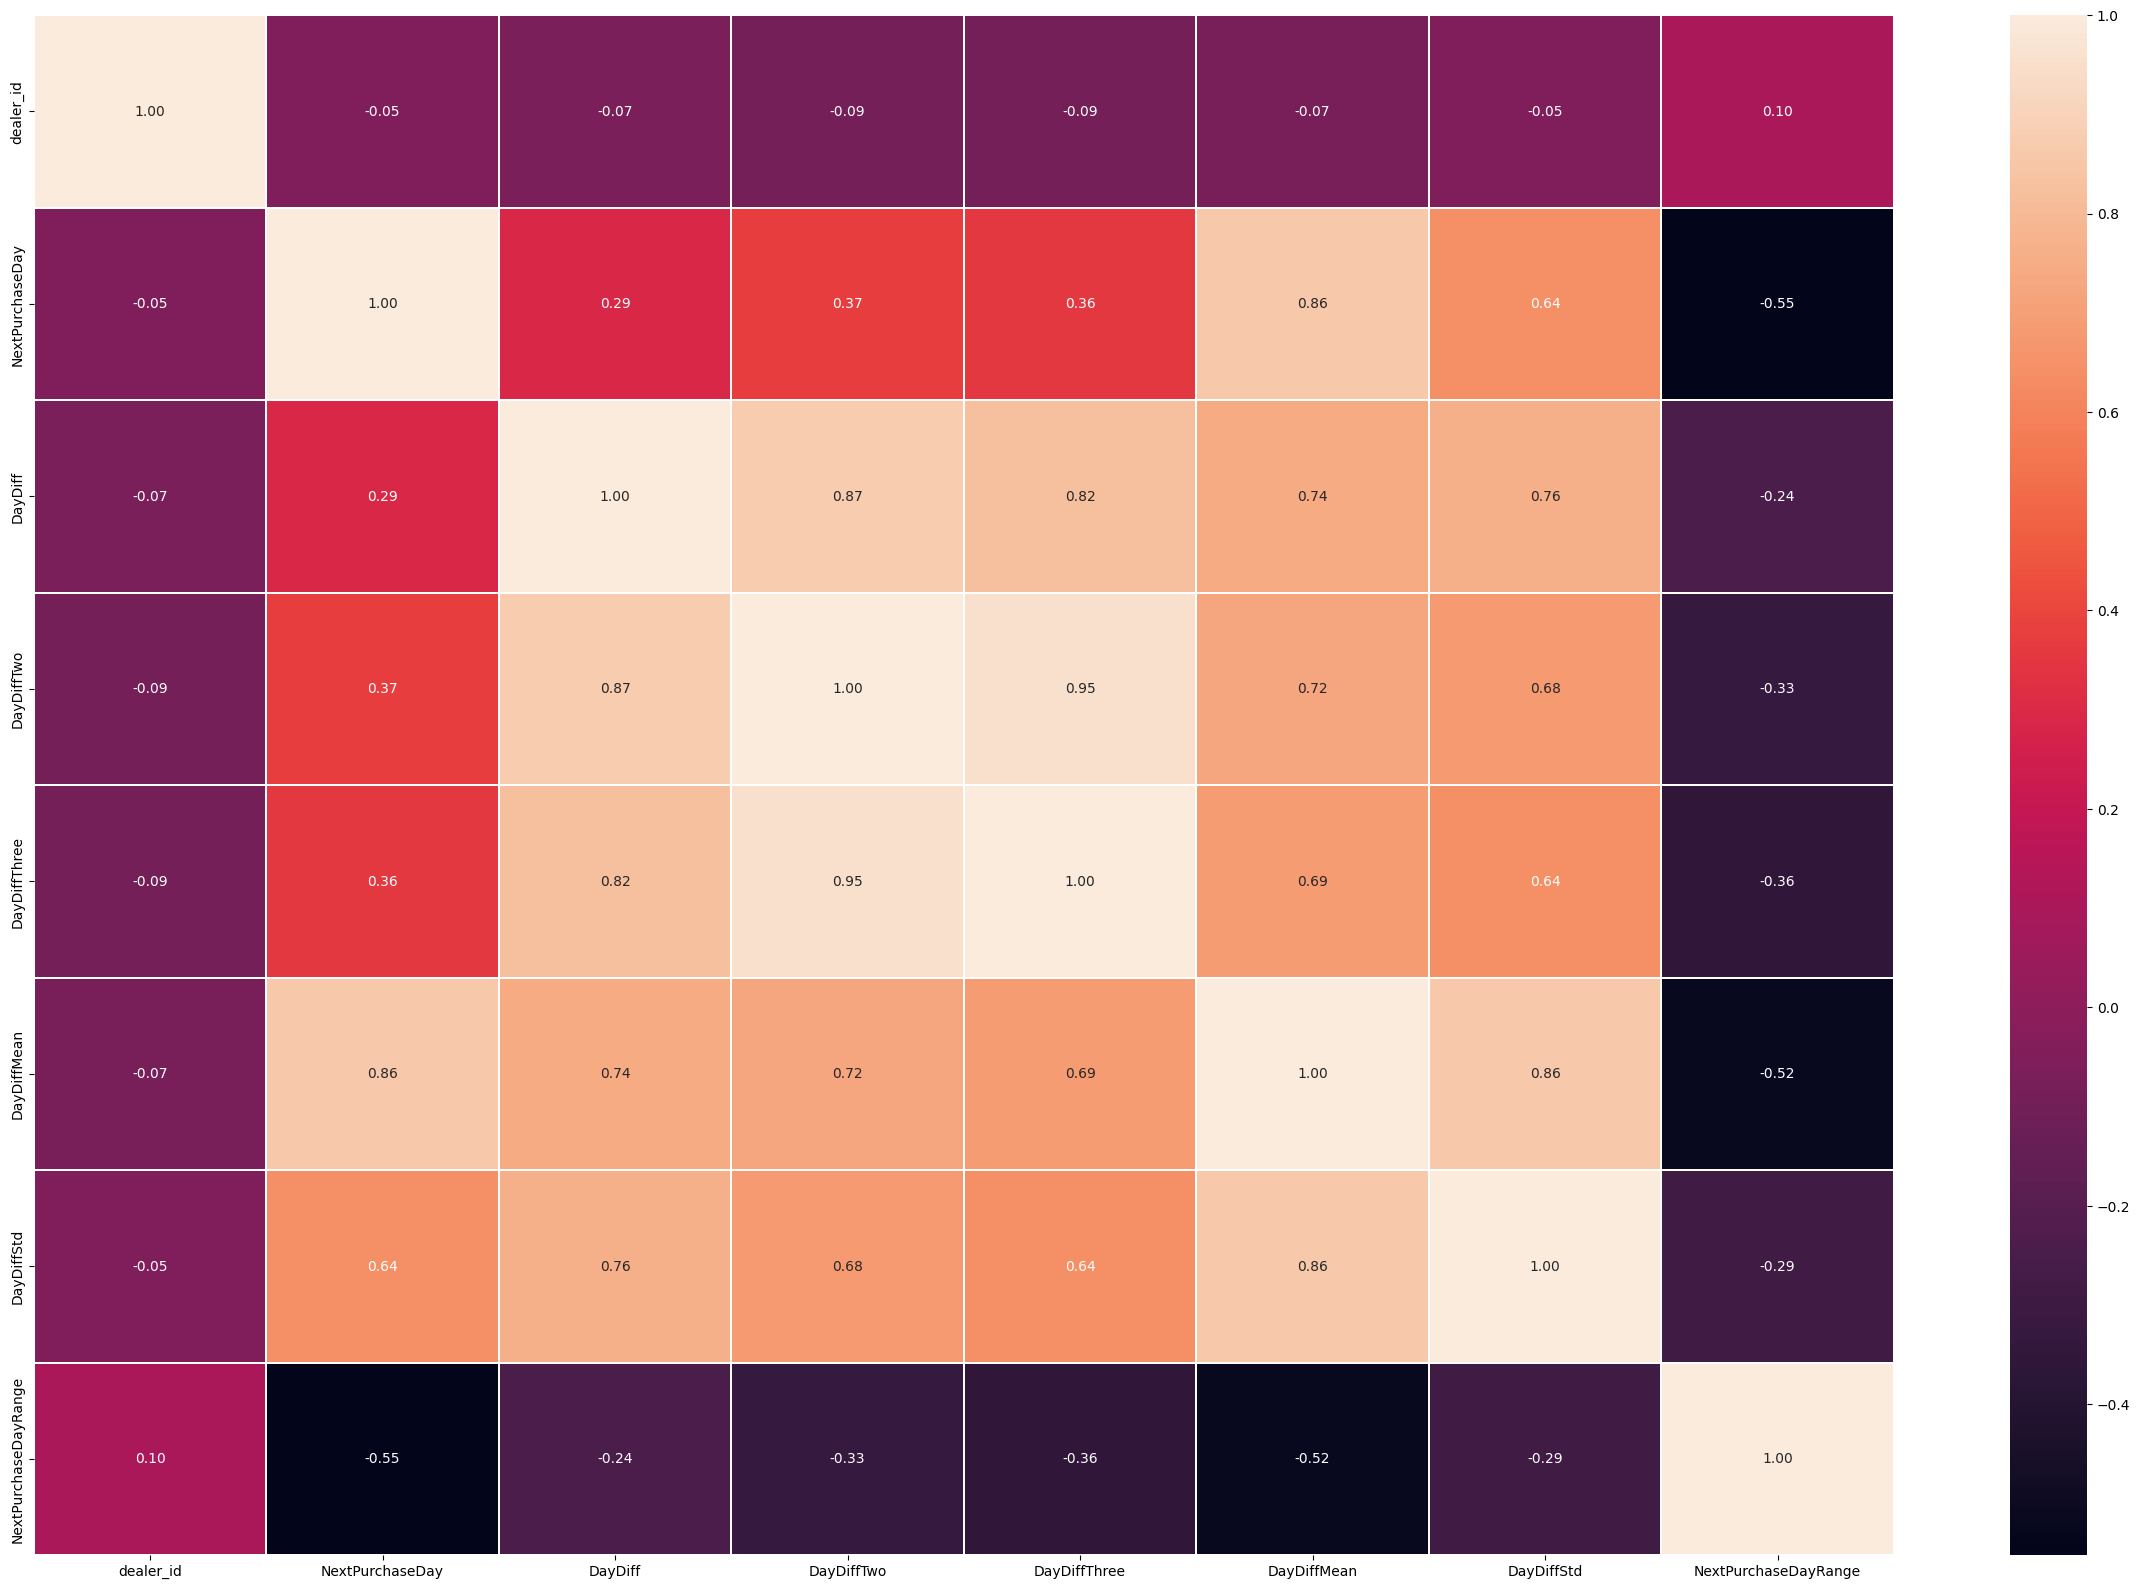

In [63]:
corr = sale_class[sale_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")
print(sale_class)

**Split the dataset**

In [64]:
from sklearn.model_selection import GroupShuffleSplit

sale_class = sale_class.drop('NextPurchaseDay', axis=1)
x, y = sale_class.drop('NextPurchaseDayRange', axis=1), sale_class['NextPurchaseDayRange']
groups = sale_class['dealer_id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=44)
for train_idx, test_idx in gss.split(x, y, groups=groups):
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

**Printing both training sets**

In [65]:
print('X_train: \n', X_train)
print('y_train: \n', y_train)

X_train: 
      dealer_id  DayDiff  DayDiffTwo  DayDiffThree  DayDiffMean  DayDiffStd
0         4886     64.0        97.0         129.0        36.75   25.889187
1         8045     43.0        86.0         109.0        53.25    8.460693
2        11702     10.0        64.0          79.0        13.25    7.365460
4        12280     11.0        44.0          53.0        41.75   37.827459
6        12634     27.0        97.0         151.0        65.50   34.229617
..         ...      ...         ...           ...          ...         ...
223  232931295      8.0        14.0          29.0        14.25    4.272002
224  232934447     24.0        43.0          85.0        19.00   10.677078
225  232935806     22.0        26.0          37.0        12.50    8.962886
226  232962603     21.0        29.0          32.0         8.75    8.421203
227  232968663      1.0         3.0          12.0         2.75    2.217356

[182 rows x 6 columns]
y_train: 
 0      0
1      0
2      1
4      0
6      0
      ..


**Creating an array of models**

In [66]:
#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


**Measuring accuracy**

In [67]:
#measure the accuracy
for name,model in models:
    kfold = KFold(n_splits=2, random_state=None)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)
    #This results as Random Forest being the one model with the highest accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LR [0.71428571 0.64835165]
NB [0.71428571 0.47252747]
RF [0.91208791 0.91208791]
SVC [0.71428571 0.8021978 ]
Dtree [0.86813187 0.94505495]
XGB [0.87912088 0.94505495]
KNN [0.71428571 0.8021978 ]


**Checking accuracy with XGBoost**

In [50]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.98


**Checking accuracy with Random Forest**

In [51]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Tuned XGB
xgb_tuned = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, random_state=None)
xgb_tuned.fit(X_train, y_train)
print("Tuned XGB train accuracy:", xgb_tuned.score(X_train, y_train))
print("Tuned XGB test accuracy:", xgb_tuned.score(X_test, y_test))

# RF
rf = RandomForestClassifier(random_state=None)
rf.fit(X_train, y_train)
print("RF train accuracy:", rf.score(X_train, y_train))
print("RF test accuracy:", rf.score(X_test, y_test))

Tuned XGB train accuracy: 1.0
Tuned XGB test accuracy: 0.9782608695652174
RF train accuracy: 1.0
RF test accuracy: 0.9782608695652174


**Selecting Model**

In [84]:
# Define and fit Random Forest
model = RandomForestClassifier(random_state=44, n_estimators=100)  # 100 trees by default
model.fit(X_train, y_train)  # Train the model
print(X_train.head(100))

     dealer_id  DayDiff  DayDiffTwo  DayDiffThree  DayDiffMean  DayDiffStd
0         4886     64.0        97.0         129.0        36.75   25.889187
1         8045     43.0        86.0         109.0        53.25    8.460693
2        11702     10.0        64.0          79.0        13.25    7.365460
4        12280     11.0        44.0          53.0        41.75   37.827459
6        12634     27.0        97.0         151.0        65.50   34.229617
..         ...      ...         ...           ...          ...         ...
120    2205356     85.0       117.0         146.0        49.25   36.935755
121    2205795     18.0        32.0          95.0        13.75    7.410578
122    2209109     30.0        69.0         122.0        26.75   19.989581
123    2210651     35.0        90.0         172.0        33.25   13.865425
124    2210653     39.0        67.0          88.0        31.50   15.022206

[100 rows x 6 columns]


In [90]:
from datetime import timedelta

# Predict for dealer_id = 4886
dealer_data = sale_class[sale_class['dealer_id'] == 4886].iloc[-1:]  # Last row
X_new = dealer_data.drop(['NextPurchaseDayRange'], axis=1)  # Match X_train format
prediction = model.predict(X_train[sale_class['dealer_id'] == 4886])
print("Predicted NextPurchaseDayRange:", prediction[0])

# Convert to date
range_mapping = {0: 51, 1: 35, 2: 10}  # Minimums or midpoints
last_purchase = pd.to_datetime("2025-02-18")
days_to_add = range_mapping[prediction[0]]
next_purchase_date = last_purchase + timedelta(days=days_to_add)
print("Predicted next purchase date:", next_purchase_date)


Predicted NextPurchaseDayRange: 0
Predicted next purchase date: 2025-04-10 00:00:00


<ipython-input-90-6b99813005a5>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prediction = model.predict(X_train[sale_class['dealer_id'] == 4886])
